In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
!pip install snowflake-sqlalchemy


In [36]:
import os
from sqlalchemy import create_engine, text
import pandas as pd
from dotenv import load_dotenv

load_dotenv() 

# Obtener credenciales desde variables de entorno
USER = os.getenv("SNOWFLAKE_USER")
PASSWORD = os.getenv("SNOWFLAKE_PASSWORD")
ACCOUNT = os.getenv("SNOWFLAKE_ACCOUNT")
DATABASE = os.getenv("SNOWFLAKE_DATABASE")
SCHEMA = os.getenv("SNOWFLAKE_SCHEMA_CLEAN")
WAREHOUSE = os.getenv("SNOWFLAKE_WAREHOUSE")

print(f"USER: {USER}")
print(f"ACCOUNT: {ACCOUNT}")
print(f"DATABASE: {DATABASE}")
print(f"SCHEMA: {SCHEMA}")


# Crear la conexión usando SQLAlchemy
engine = create_engine(
    f"snowflake://{USER}:{PASSWORD}@{ACCOUNT}/{DATABASE}/{SCHEMA}?warehouse={WAREHOUSE}"
)

# Verificar conexión
try:
    with engine.connect() as conn:
        print("Conexión exitosa a Snowflake!")
except Exception as e:
    print(f"Error de conexión: {e}")


USER: Lucianav
ACCOUNT: fyqjonx-ro02327
DATABASE: INSTACART_DB
SCHEMA: CLEAN
Conexión exitosa a Snowflake!


In [37]:
# Obtener las tablas del schema con query
query_tablas = "SHOW TABLES"
df_tablas = pd.read_sql(query_tablas, engine)

table_names = df_tablas["name"].tolist()
print("Tablas encontradas:", table_names)

Tablas encontradas: ['DIM_AISLES', 'DIM_DEPARTMENTS', 'DIM_ORDERS', 'DIM_PRODUCTS', 'DIM_USERS', 'FACT_ORDERS']


In [38]:
# Extraer datos y crear tablas en dataframes
dataframes = {}  

for table in table_names:
    
    query = f"SELECT * FROM INSTACART_DB.CLEAN.{table}"
    df = pd.read_sql(query, engine)
    dataframes[table] = df
    print(f"Tabla {table} cargada con {len(df)} filas.")


Tabla DIM_AISLES cargada con 134 filas.
Tabla DIM_DEPARTMENTS cargada con 21 filas.
Tabla DIM_ORDERS cargada con 478952 filas.
Tabla DIM_PRODUCTS cargada con 49694 filas.
Tabla DIM_USERS cargada con 478952 filas.
Tabla FACT_ORDERS cargada con 4573913 filas.


Insights

/var/folders/3f/k0x4vxjx013cr_5103f5wh480000gn/T/ipykernel_35073/2101974472.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fact_orders, x="order_dow", palette="viridis")


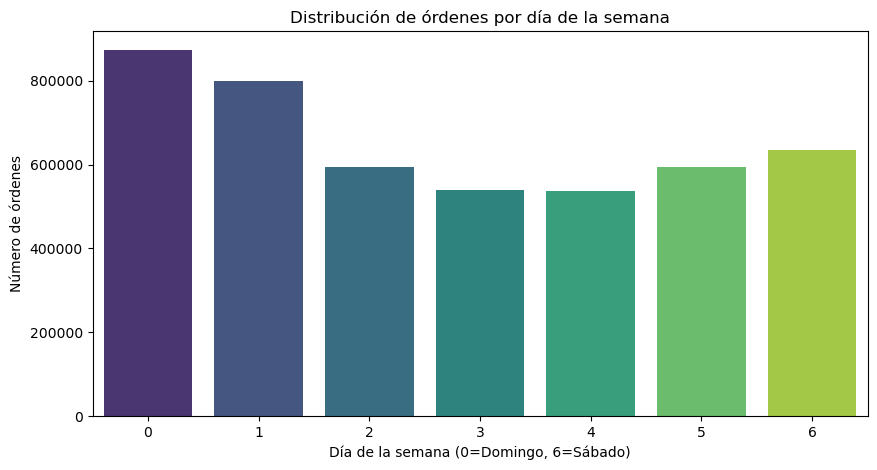

In [44]:
# Comportamiento de compra según día de la semana Analizar la distribución de órdenes por cada día (0 = domingo, 1 = lunes, etc.).

fact_orders = dataframes["FACT_ORDERS"]

plt.figure(figsize=(10, 5))
sns.countplot(data=fact_orders, x="order_dow", palette="viridis")
plt.xlabel("Día de la semana (0=Domingo, 6=Sábado)")
plt.ylabel("Número de órdenes")
plt.title("Distribución de órdenes por día de la semana")
plt.show()


/var/folders/3f/k0x4vxjx013cr_5103f5wh480000gn/T/ipykernel_35073/3755414614.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fact_orders, x="order_hour_of_day", palette="muted")


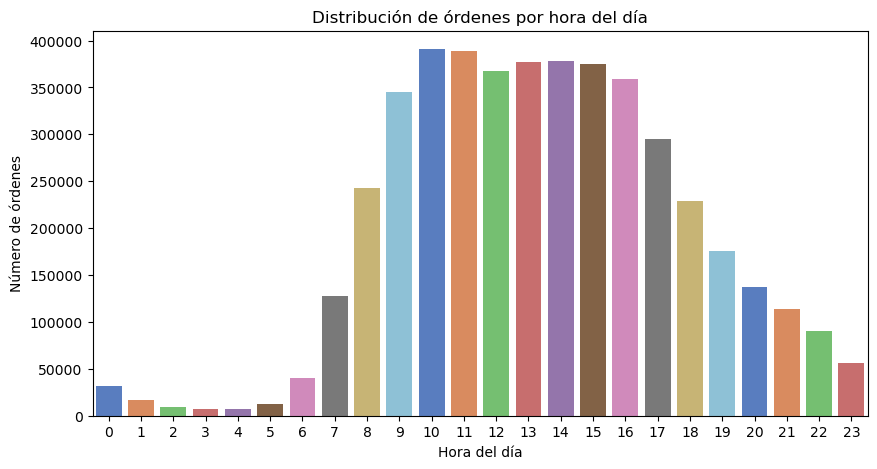

In [45]:
plt.figure(figsize=(10, 5))
sns.countplot(data=fact_orders, x="order_hour_of_day", palette="muted")
plt.xlabel("Hora del día")
plt.ylabel("Número de órdenes")
plt.title("Distribución de órdenes por hora del día")
plt.show()

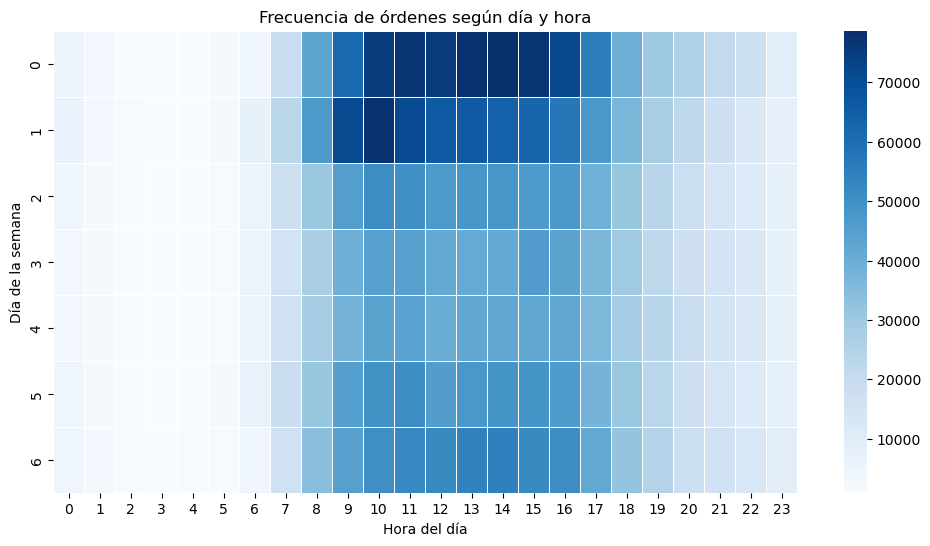

In [46]:
plt.figure(figsize=(12, 6))
sns.heatmap(fact_orders.pivot_table(index="order_dow", columns="order_hour_of_day", values="order_id", aggfunc="count"),
            cmap="Blues", linewidths=0.5)
plt.xlabel("Hora del día")
plt.ylabel("Día de la semana")
plt.title("Frecuencia de órdenes según día y hora")
plt.show()

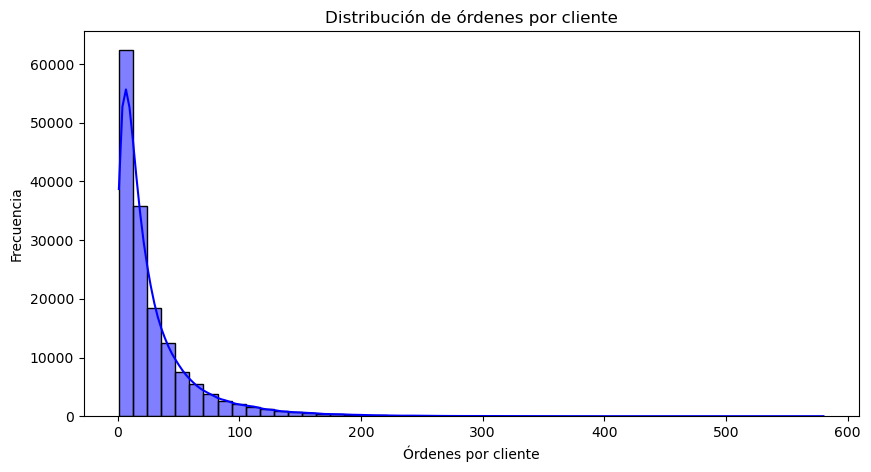

In [48]:
plt.figure(figsize=(10, 5))
sns.histplot(fact_orders.groupby("user_id")["order_id"].count(), bins=50, kde=True, color="blue")
plt.xlabel("Órdenes por cliente")
plt.ylabel("Frecuencia")
plt.title("Distribución de órdenes por cliente")
plt.show()

/var/folders/3f/k0x4vxjx013cr_5103f5wh480000gn/T/ipykernel_35073/4055496392.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20.index, y=top_20.values, palette="viridis")


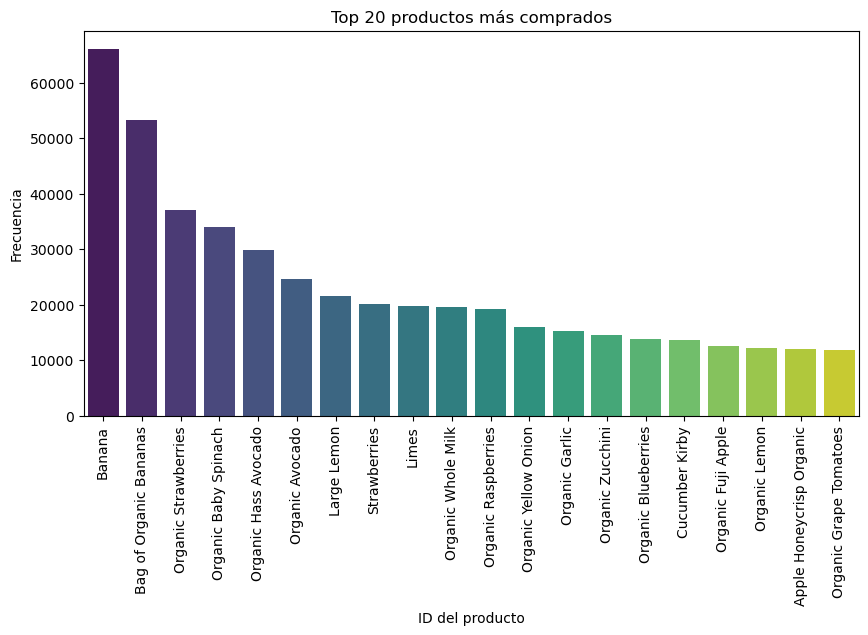

In [57]:
# Top 20 productos más frecuentes**
top_20 = fact_orders["product_id"].value_counts().head(20)
#Nombrar productos dim_products
dim_products = dataframes["DIM_PRODUCTS"]
top_20 = top_20.rename(dim_products.set_index("product_id")["product_name"])

plt.figure(figsize=(10, 5))
sns.barplot(x=top_20.index, y=top_20.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("ID del producto")
plt.ylabel("Frecuencia")
plt.title("Top 20 productos más comprados")
plt.show()

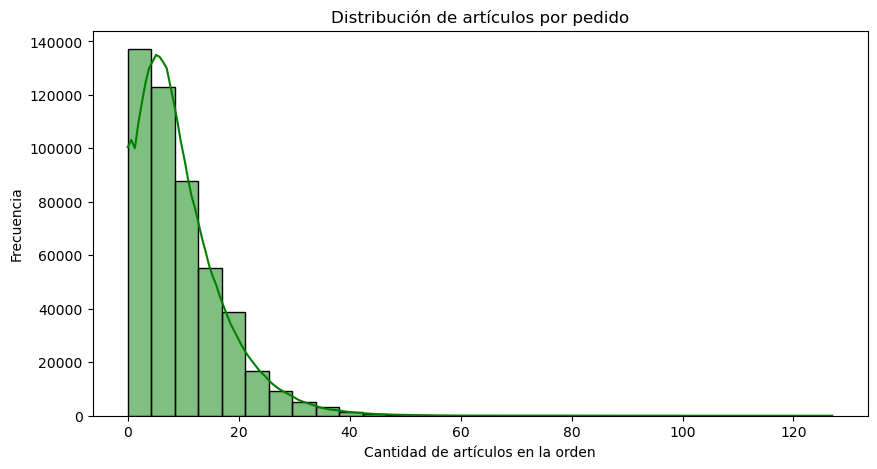

In [58]:
plt.figure(figsize=(10, 5))
sns.histplot(fact_orders.groupby("order_id")["product_id"].count(), bins=30, kde=True, color="green")
plt.xlabel("Cantidad de artículos en la orden")
plt.ylabel("Frecuencia")
plt.title("Distribución de artículos por pedido")
plt.show()

/var/folders/3f/k0x4vxjx013cr_5103f5wh480000gn/T/ipykernel_35073/523971173.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reordered.index, y=top_reordered.values, palette="rocket")


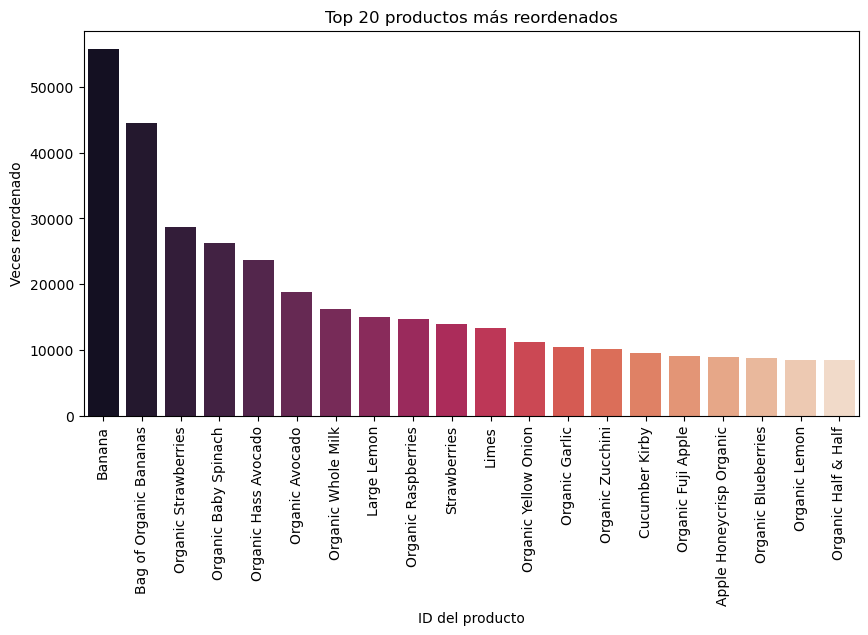

In [60]:
top_reordered = fact_orders[fact_orders["reordered"] == 1]["product_id"].value_counts().head(20)
top_reordered = top_reordered.rename(dim_products.set_index("product_id")["product_name"])
plt.figure(figsize=(10, 5))
sns.barplot(x=top_reordered.index, y=top_reordered.values, palette="rocket")
plt.xticks(rotation=90)
plt.xlabel("ID del producto")
plt.ylabel("Veces reordenado")
plt.title("Top 20 productos más reordenados")
plt.show()

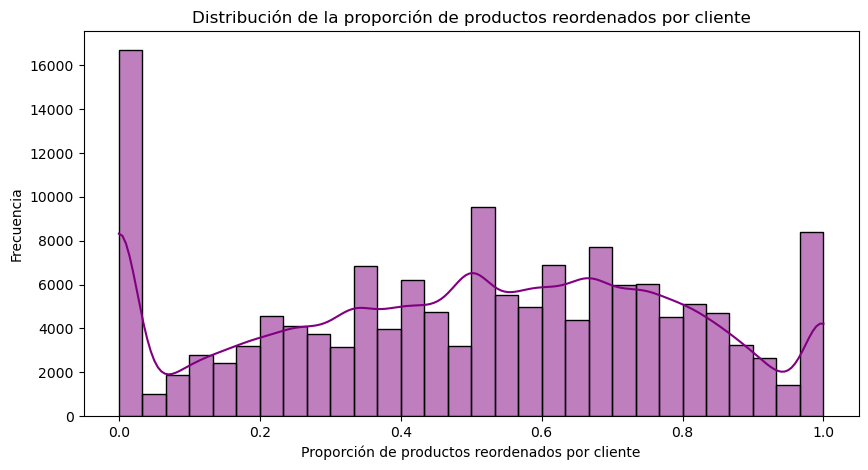

In [61]:
customer_reorder = fact_orders.groupby("user_id")["reordered"].mean()
plt.figure(figsize=(10, 5))
sns.histplot(customer_reorder, bins=30, kde=True, color="purple")
plt.xlabel("Proporción de productos reordenados por cliente")
plt.ylabel("Frecuencia")
plt.title("Distribución de la proporción de productos reordenados por cliente")
plt.show()

/var/folders/3f/k0x4vxjx013cr_5103f5wh480000gn/T/ipykernel_35073/4082045933.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_first_products.index, y=top_first_products.values, palette="coolwarm")


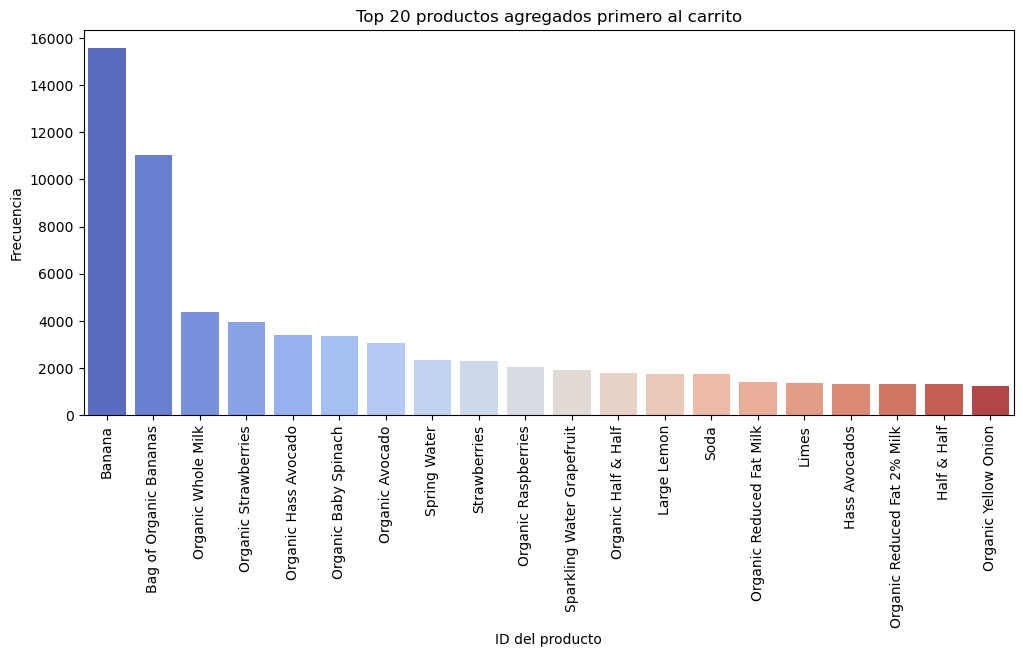

In [64]:
# Filtrar productos que fueron agregados en la primera posición del carrito
first_in_cart = fact_orders[fact_orders["add_to_cart_order"] == 1]

# Contar los productos más frecuentes en la primera posición
top_first_products = first_in_cart["product_id"].value_counts().head(20)
#renombrar
top_first_products = top_first_products.rename(dim_products.set_index("product_id")["product_name"])

# Graficar los resultados
plt.figure(figsize=(12, 5))
sns.barplot(x=top_first_products.index, y=top_first_products.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("ID del producto")
plt.ylabel("Frecuencia")
plt.title("Top 20 productos agregados primero al carrito")
plt.show()
